# SETUP

In [1]:
num_gaussians = 4

In [2]:
import time
beginning_time = time.time()

import sys
sys.path.append("../Code/")
from utils import performance

import os
DATA_DIR = os.path.join('..', 'Data')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

In [3]:
def timtime(t):
    print(">",int(time.time()- t), "seconds elapsed")

# LOAD DATA

In [4]:
# sparse might be important?

develop = False
        
train_X = pd.concat([pd.read_pickle(os.path.join(DATA_DIR, 'train_X_1')), 
                     pd.read_pickle(os.path.join(DATA_DIR, 'train_X_2'))])
train_y = pd.read_pickle(os.path.join(DATA_DIR, 'train_y'))
valid_X = pd.read_pickle(os.path.join(DATA_DIR, 'valid_X'))
valid_y = pd.read_pickle(os.path.join(DATA_DIR, 'valid_y'))

if develop:
    train_X = train_X[0:10000]
    train_y = train_y[0:10000]
    valid_X = valid_X[0:1000]
    valid_y = valid_y[0:1000]

In [5]:
test_X = pd.read_pickle(os.path.join(DATA_DIR, 'test_X'))

# Build GMM

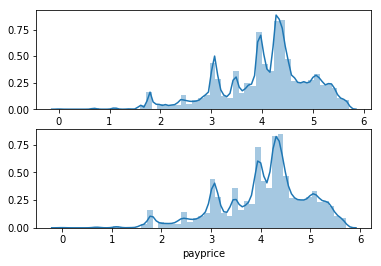

In [6]:
# first visualise data
f, (ax1, ax2) = plt.subplots(2)

sns.distplot(np.log1p(train_y.payprice), ax=ax1)
ax1.set_xlabel('Train log normal pay price')

sns.distplot(np.log1p(valid_y.payprice), ax=ax2)
ax1.set_xlabel('Valid log normal pay price')

plt.show()

In [7]:
from sklearn.mixture import GaussianMixture
GMM = GaussianMixture(n_components=num_gaussians, max_iter=100, random_state=1)

train_payprice = np.array(np.log1p(train_y.payprice))
# need two dimensions
a = np.shape(train_payprice)[0]
tpp2d = np.reshape(train_payprice, (a,1))

In [8]:
GMM.fit(tpp2d)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=4, n_init=1, precisions_init=None,
        random_state=1, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [9]:
# now sample from the GMM to check visually that it has fit the data
N = len(train_y)

sample_x, sample_y = GMM.sample(n_samples=N)

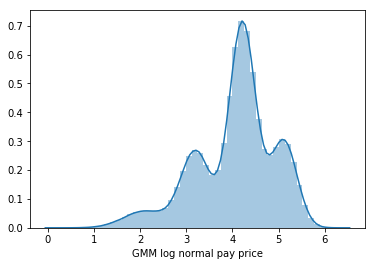

In [28]:
sns.distplot(sample_x)
plt.xlabel('GMM log normal pay price')
plt.show()

In [12]:
GMM.means_

array([[ 4.21899942],
       [ 2.10876843],
       [ 3.19960096],
       [ 5.11372412]])

In [13]:
GMM.covariances_

array([[[ 0.07806111]],

       [[ 0.21396668]],

       [[ 0.09772781]],

       [[ 0.07946261]]])

# Price category classifier

In [11]:
from scipy.sparse import csr_matrix
train_X = csr_matrix(train_X) 
valid_X = csr_matrix(valid_X)

In [14]:
from sklearn.metrics import log_loss #<--- think this should be the loss funciton

In [15]:
train_true_classes = GMM.predict(tpp2d)

In [16]:
#make a validation set
valid_payprice = np.array(np.log1p(valid_y.payprice))
a = np.shape(valid_payprice)[0]
vpp2d = np.reshape(valid_payprice, (a,1))

valid_true_classes = GMM.predict(vpp2d)

In [17]:
from xgboost import XGBClassifier

In [18]:
# check if classes are inbalanced
for c in range(num_gaussians):
    print("class:",c,"-- members:", np.sum(train_true_classes==c), 
         "-- percent", 100*(np.sum(train_true_classes==c))//len(train_true_classes))

class: 0 -- members: 1259207 -- percent 51
class: 1 -- members: 161746 -- percent 6
class: 2 -- members: 499777 -- percent 20
class: 3 -- members: 510251 -- percent 20


In [23]:
model = XGBClassifier(max_depth=10, learning_rate=0.1, n_estimators=120, 
                      random_state=0, objective="multi:softmax", 
                     max_delta_step=1)

In [24]:
model.fit(train_X, train_true_classes, eval_set=[(valid_X, valid_true_classes)], 
                   verbose=True, early_stopping_rounds=3)

[0]	validation_0-merror:0.326854
Will train until validation_0-merror hasn't improved in 3 rounds.
[1]	validation_0-merror:0.325534
[2]	validation_0-merror:0.324254
[3]	validation_0-merror:0.322478
[4]	validation_0-merror:0.322382
[5]	validation_0-merror:0.320237
[6]	validation_0-merror:0.318743
[7]	validation_0-merror:0.317819
[8]	validation_0-merror:0.316983
[9]	validation_0-merror:0.316864
[10]	validation_0-merror:0.317026
[11]	validation_0-merror:0.31672
[12]	validation_0-merror:0.316187
[13]	validation_0-merror:0.31589
[14]	validation_0-merror:0.315782
[15]	validation_0-merror:0.315594
[16]	validation_0-merror:0.315232
[17]	validation_0-merror:0.315094
[18]	validation_0-merror:0.314943
[19]	validation_0-merror:0.314535
[20]	validation_0-merror:0.314357
[21]	validation_0-merror:0.314242
[22]	validation_0-merror:0.313929
[23]	validation_0-merror:0.313482
[24]	validation_0-merror:0.313521
[25]	validation_0-merror:0.313567
[26]	validation_0-merror:0.313442
[27]	validation_0-merror:0.3

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=1,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=120,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

model = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

In [22]:
######### SAVE THE GMM AND THE DISTRIBUTION PREDICTOR ############
import pickle


GMM_filename = "../Models/SatGMM4"
with open(GMM_filename, 'wb') as file:
    pickle.dump(GMM, file)

    
XGB_filename = "../Models/SatXGDistPred"
with open (XGB_filename, 'wb') as file:
    pickle.dump(model, file)

In [25]:
XGB_filename = "../Models/SatXGDistPred2"
with open (XGB_filename, 'wb') as file:
    pickle.dump(model, file)

In [26]:
model.predict(valid_X)

array([2, 2, 0, ..., 3, 0, 0])

In [27]:
train_X.columns

AttributeError: columns not found

In [20]:
## could check the MSE to see if it is close to 8000

In [21]:
train_pred_class = model.predict(train_X)

In [22]:
# check if classes are inbalanced
for c in range(num_gaussians):
    print("class:",c,"-- members:", np.sum(train_true_classes==c), 
         "-- percent", 100*(np.sum(train_true_classes==c))//len(train_true_classes))

class: 0 -- members: 1259207 -- percent 51
class: 1 -- members: 161746 -- percent 6
class: 2 -- members: 499777 -- percent 20
class: 3 -- members: 510251 -- percent 20


In [23]:
# check if classes are inbalanced
for c in range(num_gaussians):
    print("class:",c,"-- members:", np.sum(train_pred_class==c), 
         "-- percent", 100*(np.sum(train_pred_class==c))//len(train_true_classes))

class: 0 -- members: 1699665 -- percent 69
class: 1 -- members: 95401 -- percent 3
class: 2 -- members: 347532 -- percent 14
class: 3 -- members: 288383 -- percent 11


In [24]:
L = len(train_y)

train_gauss_price = np.zeros(L)
train_predict_price = np.zeros(L)

for x in range(L):
    c1 = train_true_classes[x]
    p1 = GMM.means_[c1,0]
    train_gauss_price[x] = p1
    
    c2 = train_pred_class[x]
    p2 = GMM.means_[c2,0]
    train_predict_price[x] = p2

train_gauss_price = np.expm1(train_gauss_price)    
train_predict_price = np.expm1(train_predict_price)

In [25]:
np.expm1(GMM.means_)

array([[  66.9654455 ],
       [   7.23808926],
       [  23.52274264],
       [ 165.28848191]])

In [26]:
from sklearn.metrics import mean_squared_error as mse

In [27]:
mse(np.log1p(train_gauss_price), np.log1p(train_predict_price))

0.52971777899201822

In [28]:
mse(train_gauss_price, train_predict_price)

2086.8757832955889

In [30]:
np.sqrt(2086)

45.672748986676943

### IS MEAN + 1 + K*standard deviation greater than the actual market price?

In [39]:
train_predict_price[0:5]

array([   7.23808926,  165.28848191,   23.52274264,   23.52274264,
        165.28848191])

In [40]:
train_gauss_price[0:5]

array([   7.23808926,   23.52274264,   23.52274264,   23.52274264,
        165.28848191])

In [44]:
np.sum(train_predict_price>train_y.payprice)/L

0.48342130193530924

In [45]:
np.sum(train_predict_price+1>train_y.payprice)/L

0.49368341422660234

In [47]:
GMM.covariances_[2,0,0]

0.097727805252170147

In [50]:
train_bid[0:10]

array([ 3.26518175,  5.81845194,  3.98113713,  3.98113713,  5.81845194,
        5.81845194,  3.98113713,  4.91748487,  4.91748487,  4.91748487])

In [51]:
for K in [0,0.5,1,1.5,2,2.5,3]:
    print("++++ k={} ++++".format(K))
    
    train_bid = np.zeros(L)
    
    for x in range(L):
        c = train_pred_class[x]
        mu = GMM.means_[c,0]
        sig = np.sqrt(GMM.covariances_[c, 0, 0])
        
        p = mu + K*sig
        train_bid[x] = p
    
    train_bid = np.expm1(train_bid)
    print(np.sum(train_bid>train_y.payprice)/L)
    print(np.sum(train_bid+1>train_y.payprice)/L)   
    print()

++++ k=0 ++++
0.483421301935
0.493683414227

++++ k=0.5 ++++
0.642053146446
0.649201289521

++++ k=1 ++++
0.757464579114
0.76847042408

++++ k=1.5 ++++
0.813374929709
0.81692699367

++++ k=2 ++++
0.848030897815
0.85039002773

++++ k=2.5 ++++
0.879202675792
0.880700013698

++++ k=3 ++++
0.904775068172
0.905921518926

